# Inference in Pyro

**This Tutorial is adapted from [https://pyro.ai/examples/intro_part_ii.html](https://pyro.ai/examples/intro_part_ii.html)*

Much of modern machine learning can be cast as approximate inference and expressed succinctly in a language like Pyro. To motivate the rest of this tutorial, let's build a generative model for a simple physical problem so that we can use Pyro's inference machinery to solve it. However, we will first import the required modules for this tutorial:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

Suppose we are trying to figure out how much something weighs ($W$), but the scale we're using is unreliable and gives slightly different answers every time we weigh the same object. We could try to compensate for this variability by integrating the noisy measurement ($M$) information with a guess ($G$) based on some prior knowledge about the object, like its density or material properties. The following model encodes this process:

$W \,|\,G \sim \mathcal{N}(G, 1)$

$M \,|\, W,\, G\, \sim \mathcal{N}(W,\frac{3}{4})$

Note that this is a model not only for our belief over weight, but also for the result of taking a measurement of it. The model corresponds to the following stochastic function:

In [6]:
def scale(guess):
    
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

## Conditioning

**The real utility of probabilistic programming is in the ability to condition generative models on observed data and infer the latent factors that might have produced that data.** In Pyro, we separate the expression of conditioning from its evaluation via inference, making it possible to write a model once and condition it on many different observations. Pyro supports constraining a model’s internal sample statements to be equal to a given set of observations.

Consider the scale example once again. Suppose we want to sample from the distribution of weight given input guess = 8.5, but now we have observed that measurement == 9.5. That is, we wish to infer the distribution:

$W\,|\,M, G \sim ?$

Pyro provides the function **pyro.condition** to allow us to constrain the values of sample statements. **pyro.condition** is a *higher-order function* that takes a *model* and a *dictionary of observations* and **returns a new model that has the same input and output signatures but always uses the given values at observed sample** statements:

In [7]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

Because it behaves just like an ordinary Python function, conditioning can be deferred or parametrized with Python's **lambda** or **def**:

In [8]:
def deferred_conditioned_scale(measurement, guess):
    
    return pyro.condition(scale, data={"measurement": measurement})(guess)

In some cases it might be more convenient to pass observations directly to individual **pyro.sample** statements instead of using **pyro.condition**. The optional obs keyword argument is reserved by **pyro.sample** for that purpose:

In [9]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    
    return pyro.sample("measurement", dist.Normal(weight, 1.), obs=9.5)

Finally, in addition to **pyro.condition** for incorporating observations, Pyro also contains **pyro.do**, an implementation of Pearl's do-operator used for causal inference with an identical interface to **pyro.condition**. **condition** and **do** can be mixed and composed freely, making Pyro a powerful tool for model-based causal inference.

## Flexible Approximate Inference With Guide Functions

Let us return to **conditioned_scale**. Now that we have conditioned on an observation of measurement, we can use Pyro's approximate inference algorithms to estimate the distribution over weight given guess and measurement == data.

Inference algorithms in Pyro, such as **pyro.infer.SVI**, allow us to use arbitrary stochastic functions, which we will call guide functions or guides, as approximate posterior distributions. Guide functions must satisfy these two criteria to be valid approximations for a particular model: 

1. All unobserved (i.e., not conditioned) sample statements that appear in the model appear in the guide. 

2. The guide has the same input signature as the model (i.e., takes the same arguments).

Guide functions can serve as **programmable, data-dependent proposal distributions** for importance sampling, rejection sampling, sequential Monte Carlo, MCMC, and independent Metropolis-Hastings, and as variational distributions or inference networks for stochastic variational inference. Currently, importance sampling, MCMC, and stochastic variational inference are implemented in Pyro (other algorithms will be added in the future).

Although the precise meaning of the guide is different across different inference algorithms, the guide function should generally be chosen so that, in principle, it is flexible enough to closely approximate the distribution over all unobserved sample statements in the model.

In the case of **scale**, it turns out that the true posterior distribution over weight given guess and measurement is actually $\mathcal{N}(9.14, 0.6)$. As the model is quite simple, we are able to determine our posterior distribution of interest analytically (for derivation, see for example Section 3.4 of [http://www.stat.cmu.edu/~brian/463-663/week09/Chapter%2003.pdf ](http://www.stat.cmu.edu/~brian/463-663/week09/Chapter%2003.pdf )).

In [12]:
def perfect_guide(guess):
    
    post_mean = (0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    post_var  = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    
    return pyro.sample("weight", dist.Normal(post_mean, post_var))

## Parametrized Stochastic Functions and Variational Inference

Although we could write out the exact posterior distribution for scale, in general it is **intractable to specify a guide that is a good approximation to the posterior distribution of an arbitrary conditioned stochastic function.** In fact, stochastic functions for which we can determine the true posterior exactly are the exception rather than the rule. For example, even a version of our scale example with a nonlinear function in the middle may be intractable:

In [13]:
def intractable_scale(guess):
    
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    
    return pyro.sample("measurement", dist.Normal(some_nonlinear_function(weight), 0.75))

What we can do instead is use the top-level function **pyro.param** to specify a family of guides indexed by named parameters, and search for the member of that family that is the best approximation according to some loss function. **This approach to approximate posterior inference is called variational inference.**

**pyro.param** is a frontend for Pyro's key-value parameter store. Like **pyro.sample**, **pyro.param** is always called with a name as its first argument. The first time **pyro.param** is called with a particular name, it stores its argument in the parameter store and then returns that value. After that, when it is called with that name, it returns the value from the parameter store regardless of any other arguments. It is similar to **simple_param_store.setdefault** here, but with some additional tracking and management functionality.

In [14]:
simple_param_store = {}
a                  = simple_param_store.setdefault("a", torch.randn(1))

For example, we can parametrize **a** and **b** in **scale_posterior_guide** instead of specifying them by hand:

In [16]:
def scale_parametrized_guide(guess):
    
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

Pyro is built to enable **stochastic variational inference**, a powerful and widely applicable class of variational inference algorithms with three key characteristics:

1. Parameters are always real-valued tensors.
2. We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide.
3. We use stochastic gradient descent to search for the optimal parameters.

Combining stochastic gradient descent with PyTorch's GPU-accelerated tensor math and automatic differentiation allows us to scale variational inference to very high-dimensional parameter spaces and massive datasets.

Pyro's SVI functionality is described in detail in an upcoming tutorial. Here is a very simple example applying it to scale:

a =  9.171734809875488
b =  0.6151190996170044


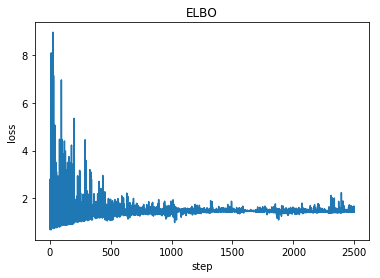

In [17]:
guess = 8.5

pyro.clear_param_store()

svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps    = 2500

for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

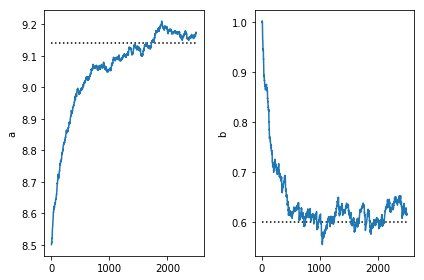

In [18]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

**Note that SVI obtains parameters very close to the true parameters of the desired conditional distribution. This is to be expected as our guide is from the same family.**

Note that optimization will update the values of the guide parameters in the parameter store, so that once we find good parameter values, we can use samples from the guide as posterior samples for downstream tasks.

In the next tutorial, we will see how models like **scale** can be augmented with deep neural networks (through Variational Autoencoders) and use stochastic variational inference to build a generative model of images. 